# Nuclear Scattering Simulation

##### *Kenji Bomar, Jon Braatz, Chase Foster, Damon Griffin, Matt Mandel*

This notebook is a complement to our presentation on kaon scattering about a carbon-12 nucleus. Here, we show the code we created to simulate kaon scattering and to generate graphs for the report. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from scattering_class import Scattering

The bulk of the simulation code is stored in a Scattering object with several methods. Throughout our simulation, we use the experimental data provided in class for reference in the simulation and for optimizing the numerical methods used therein. We first instantiate a Scattering object and read in the data. The documentation for this class is found in the attached "scattering_class.py" file. The data are originally sourced from a paper by Marlow et. al., Phys. Rev. C30, 1256-1266 (1984). 

In [2]:
exp_data = np.loadtxt('Scattering_Data.txt', delimiter=',', dtype=float)[:,1:4]

In [3]:
s = Scattering(exp_data)

We plot the experimental data with appropriate error bounds. The objective of the simulation is to use relevant quantum theory and numerical methods to approximate these experimental results. 

<IPython.core.display.Javascript object>


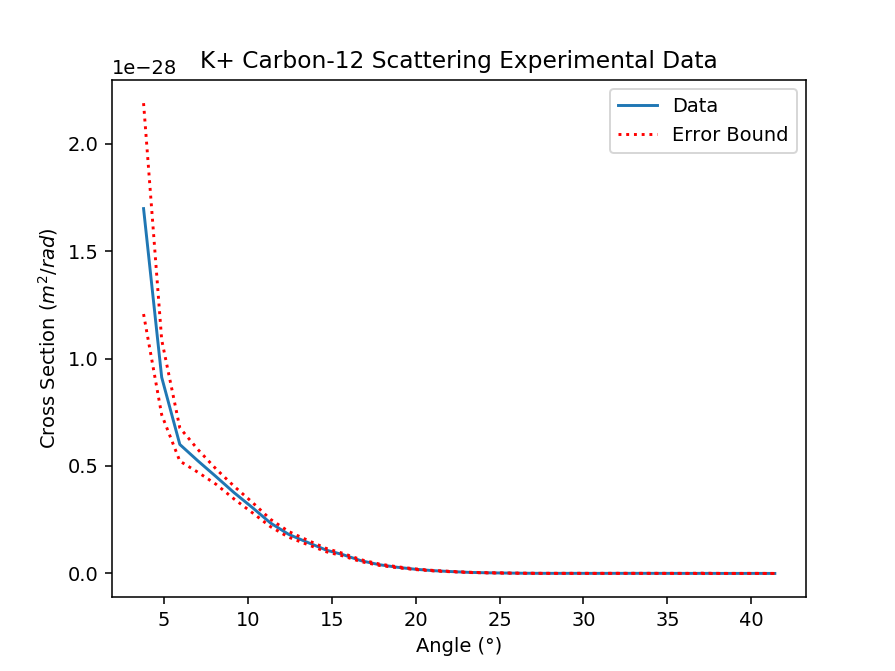

In [4]:
s.plot_experiment()

The blue curve shows kaon scattering cross sections at various angles. The red lines are the experimental error bounds for the cross section data. 

Our method of simulating this experiment is to compute scattering scross sections for kaons that result from kaon behavior in the presence of some field. Specifically, the field can be defined with some potential function $V$. The scattering amplitude about a nucleus in this field can be computed using the [Born Approximation](https://en.wikipedia.org/wiki/Born_approximation), and this method can be modified to give the differential cross section resulting from scattering at some angle $\theta$. We will compute the differential cross section for a range of angles of incidence under 3 different fields and compare the simulated results to the experimental results. 

For potentials, we use the finite square well, the Yukawa potential, and the Woods-Saxon potential, all of which are commonly used in quantum mechanics or nuclear scattering. These potentials define the fields that dictate kaon scattering. Each potential has multiple input parameters that control the field. While there are common values for these paramaters listed in the literature, it is more efficient to choose the parameters that automatically minimize some error metric between the simulated cross section data and that of the experiment. One such method is [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing). This method can be used to find the parameters for a potential that minimizes the error between the simulated data and experimental data. 

We use the sum of square errors function to measure the accuracy of the simulation. Our implementation of simulated annealing will find values of constants in the 3 potential functions that minimize the sum of square errors. The square well and Yukawa potentials have 2 parameters to find. To find the optimal parameters, we have modified the annealing code found in *Computational Physics* by Mark Newmann, P. 404, to minimize the sum of squared errors. Simulated annealing requires guessing the initial values of the parameters of the potential function, so we have chosen arbitrary values of the order typically found in the literature. 

In [5]:
well_param1, well_param2, _ = s.two_parameter_annealing('well', exp_data, 5.0e-15, -2.0e-12)

In [6]:
well_param1, well_param2

(5.115294227513286e-15, -2.098050679564156e-12)

In [7]:
yukawa_param1, yukawa_param2, _ = s.two_parameter_annealing('yukawa', exp_data, 2.5e-15, -1.3e-13)

In [8]:
yukawa_param1, yukawa_param2

(2.2437687110625412e-15, -1.189632824591533e-13)

The Woods-Saxon potential has 3 parameters to optimize, so we have modified the simulated annealing code further to optimize over 3 parameters.

In [9]:
ws_param1, ws_param2, ws_param3, _ = s.three_parameter_annealing('ws', exp_data, 2.1e-15, 1.0e-15, 8.8e-12)

/home/chase/Documents/Scattering/scattering_class.py:72: RuntimeWarning: overflow encountered in exp
  return -V_0 /(1 + np.exp((r-R)/a))


In [10]:
ws_param1, ws_param2, ws_param3

(9.472096361832524e-16, 4.631894512781615e-16, 3.787838386324143e-12)

The simulated annealing process is inherently stochastic, so variation in the input parameters is expected for repeated simulations. 

The optimal parameters can be used as input parameters for further iterations of annealing. This process helps to refine the parameters and reduce the probability that simulated annealing has found a local minimum by chance. The resultant parameters are listed below.

In [11]:
well_params = [5.261874731343652e-15, -1.9621412215115647e-12]
yukawa_params = [2.543646202990828e-15, -1.3431435062833437e-13]
ws_params = [2.1008416412803036e-15, 1.0206858107669728e-15, 8.783933e-12]

With the optimal parameters found, we now simulate cross-sectional scattering.

In [12]:
# The annealing code modifies the original data, so we need to import
# the file again to ensure the correct angles are used. 
exp_data = np.loadtxt('Scattering_Data.txt', delimiter=',', dtype=float)[:,1:4]

thetas = exp_data[:,0]*np.pi/180.0 # C.M. angle [rad]
exp_cross_sections = exp_data[:,1]*1e-31/.572 # Experimental cross section [m^2/rad]

well_cross_sections = s.cross_section_array(thetas, 'well', well_params)
yukawa_cross_sections = s.cross_section_array(thetas, 'yukawa', yukawa_params)
ws_cross_sections = s.cross_section_array(thetas, 'ws', ws_params)

We now plot the simulated data with the experimental data for comparison.

In [13]:
# Plot the values generated by the potentials.
plt.figure()
plt.plot(thetas*180.0/np.pi, well_cross_sections, label = "Square Well")
plt.plot(thetas*180.0/np.pi, yukawa_cross_sections, label = "Yukawa")
plt.plot(thetas*180.0/np.pi, ws_cross_sections, label = "Woods-Saxon")
plt.xlabel('angle (°)')
plt.ylabel('cross section ($m^2/rad$)')

# Plot the experimental data for comparison. 
plt.plot(thetas*180.0/np.pi, exp_cross_sections, 'k--', label = "Experimental") 
plt.title("Combined Results")
plt.legend()

<IPython.core.display.Javascript object>

Of the three potentials, the Yukawa potential generated cross sections that most closely matched the experimental data. All three simulations underestimated the magnitude of the cross sections in the 7-17° range, and they slightly overestimated the magnitude in the 5-7° range. It is likely the case that the potential functions used in the simulations are not sufficiently complex to accurately model the field present in the experiment. But the simulations do capture much of the pattern in the data. The cross section magnitude falls off quickly with increasing angle of incidence. 